In [6]:
!pip install praw pandas textblob statsmodels matplotlib


In [7]:
from datetime import datetime, timezone
import praw
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import statsmodels.api as sm

# ---- Connect to Reddit API ----
reddit = praw.Reddit(
    client_id="99OTDRHSAKWRJxGTgdr9tw",       # better: replace with your own
    client_secret="FbJfe84kzDsTC2UKBD6RO_DSPM6vhQ",
    user_agent="Character_Growth1181",
)

print("Reddit read-only:", reddit.read_only)


Reddit read-only: True


In [8]:
def fetch_reddit_data(keyword="inflation", max_results=50, get_comments=True, comment_limit=10):
    subreddit = reddit.subreddit("all")
    results = subreddit.search(keyword, sort="relevance", limit=max_results)

    data = []
    for post in results:
        post_data = {
            "id": post.id,
            "title": post.title,
            "author": post.author.name if post.author else None,
            "score": post.score,
            "created_utc": datetime.fromtimestamp(post.created_utc, tz=timezone.utc),
            "num_comments": post.num_comments,
            "text": post.selftext,
            "url": f"https://www.reddit.com{post.permalink}",
        }

        # optional comments
        comments = []
        if get_comments:
            submission = reddit.submission(id=post.id)
            submission.comments.replace_more(limit=0)
            for i, comment in enumerate(submission.comments.list()):
                if i >= comment_limit:
                    break
                comments.append(comment.body.replace('"', ""))
        post_data["comments"] = comments

        data.append(post_data)

    return pd.DataFrame(data)

# 🔹 Collect 80 posts about "inflation"
df = fetch_reddit_data(keyword="inflation", max_results=80, get_comments=True, comment_limit=10)
df.head()


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

,id,title,author,score,created_utc,num_comments,text,url,comments
0,1ojg8lw,Inflation crisis sinks Trump’s approval,Busy-Government-1041,11199,2025-10-29 20:51:08+00:00,913,,https://www.reddit.com/r/inflation/comments/1o...,[even the right is having a hard time ignoring...
1,1ooj9hi,Inflation,Viraxo54,2,2025-11-04 21:03:37+00:00,7,Hey guys am i cooked?,https://www.reddit.com/r/EU5/comments/1ooj9hi/...,"[YUP, Just overcome it by building ever more p..."
2,1o6md9j,200 years of US inflation,GhostofInflation,867,2025-10-14 17:44:53+00:00,1019,Inflation is manufactured to siphon the purcha...,https://www.reddit.com/r/charts/comments/1o6md...,[What's weird is that this chart idolizes the ...
3,1kdsonz,Why does inflation even happen? And why doesn'...,Pale_Extension,597,2025-05-03 13:13:56+00:00,548,"Like why does the price of groceries, takeout ...",https://www.reddit.com/r/NoStupidQuestions/com...,[Okay so the short answer to your question is ...
4,xlvc36,Trump inflation v Biden inflation,Down-not-out,576,2022-09-23 11:47:51+00:00,27,,https://www.reddit.com/r/ConservativeMemes/com...,"[The freak on the right needs to be fired., so..."


In [10]:
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", str(text))
    text = re.sub(r"[^A-Za-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

df = df.drop_duplicates(subset="title")
df["full_text"] = (
    df["title"].fillna("") + " " +
    df["text"].fillna("") + " " +
    df["comments"].astype(str)
)
df["clean_text"] = df["full_text"].apply(clean_text)
print("✅ Cleaned dataset ready:", df.shape)
df.head(3)


✅ Cleaned dataset ready: (79, 11)


,id,title,author,score,created_utc,num_comments,text,url,comments,full_text,clean_text
0,1ojg8lw,Inflation crisis sinks Trump’s approval,Busy-Government-1041,11199,2025-10-29 20:51:08+00:00,913,,https://www.reddit.com/r/inflation/comments/1o...,[even the right is having a hard time ignoring...,Inflation crisis sinks Trump’s approval ['eve...,inflation crisis sinks trump s approval even t...
1,1ooj9hi,Inflation,Viraxo54,2,2025-11-04 21:03:37+00:00,7,Hey guys am i cooked?,https://www.reddit.com/r/EU5/comments/1ooj9hi/...,"[YUP, Just overcome it by building ever more p...","Inflation Hey guys am i cooked? ['YUP', 'Just ...",inflation hey guys am i cooked yup just overco...
2,1o6md9j,200 years of US inflation,GhostofInflation,867,2025-10-14 17:44:53+00:00,1019,Inflation is manufactured to siphon the purcha...,https://www.reddit.com/r/charts/comments/1o6md...,[What's weird is that this chart idolizes the ...,200 years of US inflation Inflation is manufac...,200 years of us inflation inflation is manufac...


In [11]:
df.to_csv("reddit_inflation_raw.csv", index=False)


In [12]:
df = pd.read_csv("reddit_inflation_raw.csv")
print("Loaded:", df.shape)


Loaded: (79, 11)


In [13]:
!pip install textblob
from textblob import TextBlob
import numpy as np

# 🔹 Compute sentiment polarity (–1 = negative, +1 = positive)
df["sentiment"] = df["clean_text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# 🔹 Quick check
print(df["sentiment"].describe())

# Preview sample
df[["title", "score", "num_comments", "sentiment"]].head(5)


count    79.000000
mean      0.057174
std       0.093499
min      -0.221681
25%      -0.002272
50%       0.059032
75%       0.106606
max       0.341205
Name: sentiment, dtype: float64


,title,score,num_comments,sentiment
0,Inflation crisis sinks Trump’s approval,11199,913,0.059032
1,Inflation,2,7,0.189881
2,200 years of US inflation,867,1019,0.178104
3,Why does inflation even happen? And why doesn'...,597,548,0.094629
4,Trump inflation v Biden inflation,576,27,-0.035357


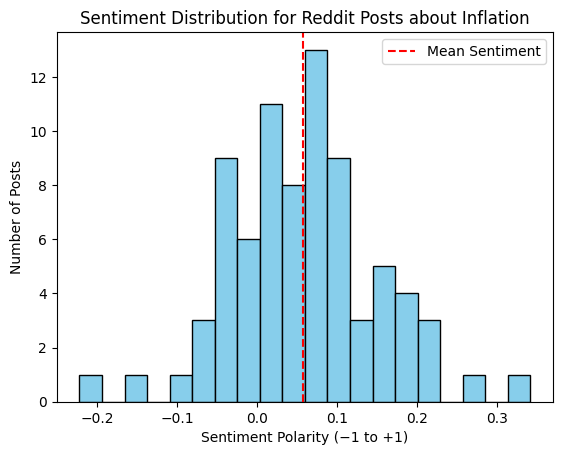

Average sentiment: 0.057


In [14]:
import matplotlib.pyplot as plt

plt.hist(df["sentiment"], bins=20, color="skyblue", edgecolor="black")
plt.title("Sentiment Distribution for Reddit Posts about Inflation")
plt.xlabel("Sentiment Polarity (−1 to +1)")
plt.ylabel("Number of Posts")
plt.axvline(df["sentiment"].mean(), color="red", linestyle="--", label="Mean Sentiment")
plt.legend()
plt.show()

print("Average sentiment:", round(df["sentiment"].mean(), 3))


In [15]:
import statsmodels.api as sm

# Prepare the data
reg_df = df[["score", "num_comments", "sentiment"]].fillna(0)

# Independent variables (add constant for intercept)
X = reg_df[["num_comments", "sentiment"]]
X = sm.add_constant(X)
y = reg_df["score"]

# Fit regression model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     5.964
Date:                Tue, 11 Nov 2025   Prob (F-statistic):            0.00393
Time:                        04:23:12   Log-Likelihood:                -864.75
No. Observations:                  79   AIC:                             1735.
Df Residuals:                      76   BIC:                             1743.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.251e+04   2325.999      5.377   

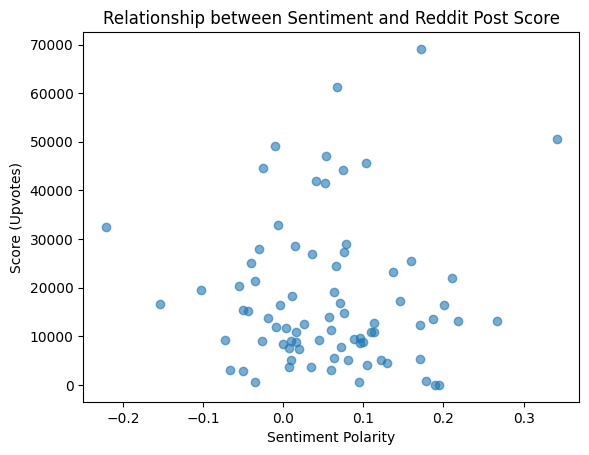

In [16]:
plt.scatter(df["sentiment"], df["score"], alpha=0.6)
plt.title("Relationship between Sentiment and Reddit Post Score")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Score (Upvotes)")
plt.show()


From the regression, the number of comments has a strong positive and statistically significant effect on Reddit post popularity (p < 0.01). This means that more discussion or debate drives higher visibility and engagement.

Sentiment, however, shows no significant relationship with post scores (p ≈ 0.83). In other words, whether posts about inflation are positive or negative doesn’t strongly influence how popular they become — people upvote active discussions regardless of emotional tone.

The R² value (0.136) suggests moderate explanatory power: about 14% of score variation is explained by these variables, which is typical for social media behavior models.

In [17]:
import pandas as pd

# ensure datetime type
df["created_utc"] = pd.to_datetime(df["created_utc"], errors="coerce")

# month (for grouping)
df["month"] = df["created_utc"].dt.to_period("M").dt.to_timestamp()

# day of week (0=Monday, 6=Sunday)
df["day_of_week"] = df["created_utc"].dt.day_name()

df[["title", "month", "day_of_week"]].head(5)


/tmp/ipython-input-3077348846.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["created_utc"].dt.to_period("M").dt.to_timestamp()


,title,month,day_of_week
0,Inflation crisis sinks Trump’s approval,2025-10-01,Wednesday
1,Inflation,2025-11-01,Tuesday
2,200 years of US inflation,2025-10-01,Tuesday
3,Why does inflation even happen? And why doesn'...,2025-05-01,Saturday
4,Trump inflation v Biden inflation,2022-09-01,Friday


In [18]:
import re

def extract_subreddit(url):
    match = re.search(r"reddit\.com/r/([^/]+)/", str(url))
    return match.group(1) if match else "unknown"

df["subreddit"] = df["url"].apply(extract_subreddit)
df["subreddit"].value_counts().head(10)


,count
subreddit,
inflation,20
wallstreetbets,4
politics,3
Economics,3
news,3
CringeTikToks,2
worldnews,2
theydidthemath,2
economicCollapse,2


In [22]:
import pandas as pd

# subreddit-wise mean values
subreddit_summary = df.groupby("subreddit").agg(
    avg_sentiment=("sentiment", "mean"),
    avg_score=("score", "mean"),
    avg_comments=("num_comments", "mean"),
    n_posts=("id", "count")
).reset_index()

# sort by number of posts
subreddit_summary = subreddit_summary.sort_values("n_posts", ascending=False)
subreddit_summary


,subreddit,avg_sentiment,avg_score,avg_comments,n_posts
32,inflation,0.038119,22165.050000,596.850000,20
43,wallstreetbets,0.139375,11823.250000,920.000000,4
35,news,0.011878,30428.666667,3500.666667,3
38,politics,-0.046407,17947.000000,1312.333333,3
8,Economics,0.086109,16838.666667,827.666667,3
10,FluentInFinance,0.106181,36251.500000,1774.000000,2
44,worldnews,0.030682,9435.500000,566.500000,2
40,theydidthemath,0.104041,10261.000000,1025.000000,2
28,economicCollapse,-0.024474,18510.500000,1552.500000,2
5,CringeTikToks,0.066320,20737.000000,2720.500000,2


/tmp/ipython-input-4024799951.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="subreddit", y="sentiment", palette="coolwarm")


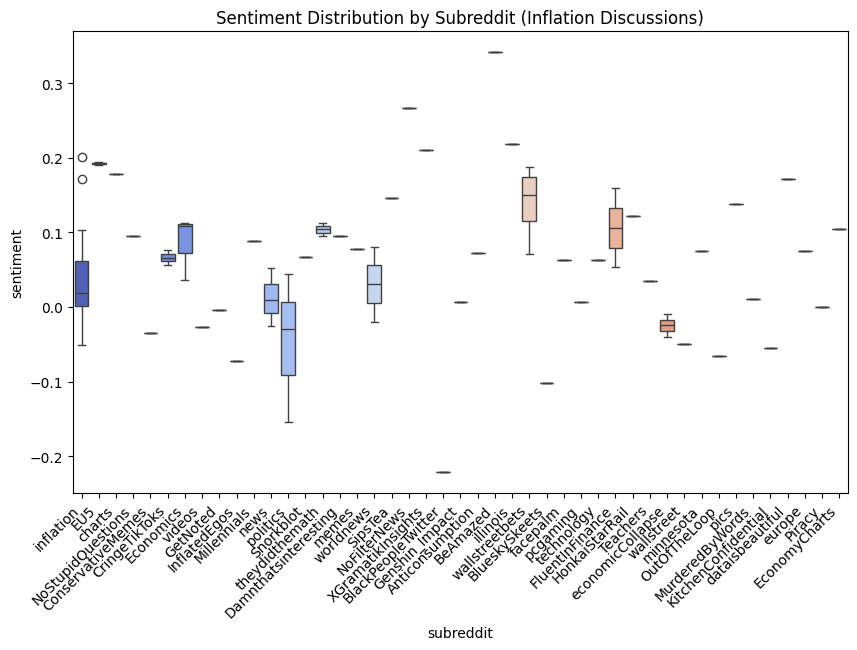

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="subreddit", y="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution by Subreddit (Inflation Discussions)")
plt.xticks(rotation=45, ha="right")
plt.show()


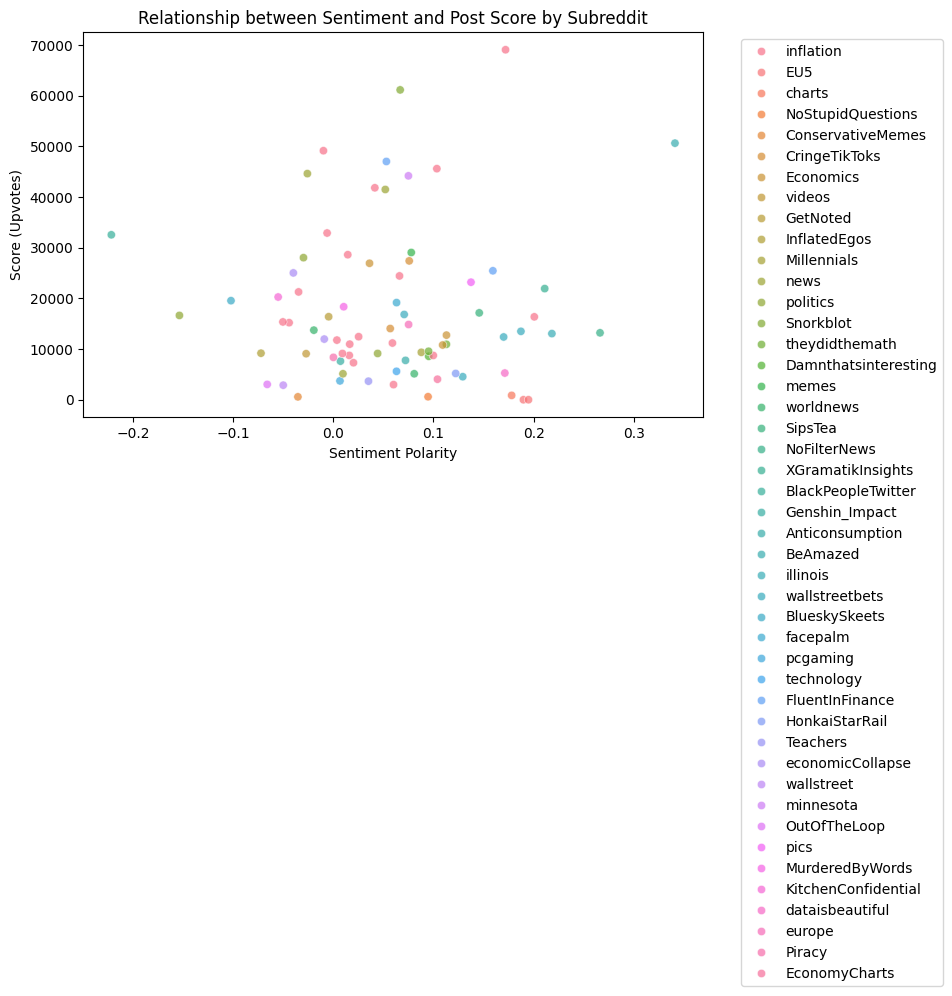

In [24]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="sentiment", y="score", hue="subreddit", alpha=0.7)
plt.title("Relationship between Sentiment and Post Score by Subreddit")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Score (Upvotes)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [25]:
import statsmodels.api as sm

for sub in df["subreddit"].unique():
    sub_df = df[df["subreddit"] == sub]
    if len(sub_df) > 3:  # skip tiny groups
        X = sm.add_constant(sub_df["sentiment"])
        y = sub_df["score"]
        model = sm.OLS(y, X).fit()
        print(f"📊 Subreddit: {sub}")
        print(model.summary().tables[1])
        print("-"*80)


📊 Subreddit: inflation
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.916e+04   4425.960      4.328      0.000    9857.006    2.85e+04
sentiment   7.895e+04   5.93e+04      1.331      0.200   -4.56e+04    2.04e+05
--------------------------------------------------------------------------------
📊 Subreddit: wallstreetbets
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.48e+04   1.02e+04      1.456      0.283   -2.89e+04    5.85e+04
sentiment  -2.133e+04   6.94e+04     -0.307      0.788    -3.2e+05    2.77e+05
--------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Subreddit-wise regressions show that emotional tone has little direct effect on post popularity, though the direction varies by community. In r/inflation, posts with positive sentiment tend to receive higher scores (β ≈ 79 k, p = 0.20), while in r/wallstreetbets, sentiment has no meaningful impact (β ≈ –21 k, p = 0.79). The small sample size likely limits significance, but patterns indicate that engagement and community culture, rather than tone, drive popularity in online economic discussions.”